• **DOMAIN**: Health Care

• **CONTEXT**:
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation
of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical
images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

• **DATA DESCRIPTION**:
- In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was
determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the
appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original link to the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data [ for your reference
only ]. You can refer to the details of the dataset in the above link
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

• **PROJECT OBJECTIVE**: Design a DL based algorithm for detecting pneumonia

#**PROJECT TASK**

##**Milestone 1**

**Process**:
1. Import the data.
2. Map training and testing images to its classes.
3. Map training and testing images to its annotations.
4. Preprocessing and Visualisation of different classes
5. Display images with bounding box.
6. Design, train and test basic CNN models for classification.
7. Interim report

**Import the data**

In [1]:
import pandas as pd
import numpy as np
import cv2

import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model


import random
from tensorflow.keras import backend

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from skimage.transform import resize
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import warnings
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/My Drive/AIML/Capstone Project/'

train_labels=pd.read_csv(data_dir +'stage_2_train_labels.csv')

In [4]:
sample_submission=pd.read_csv(data_dir +'stage_2_sample_submission.csv')

In [5]:
class_info=pd.read_csv(data_dir +'stage_2_detailed_class_info.csv')

In [6]:
print("train_labels \n" , train_labels.dtypes)
print("\n")
print("sample_submission \n", sample_submission.dtypes)
print("\n")
print("class_info \n", class_info.dtypes)

train_labels 
 patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object


sample_submission 
 patientId           object
PredictionString    object
dtype: object


class_info 
 patientId    object
class        object
dtype: object


In [7]:
print(train_labels.info())
print("\n")
print(sample_submission.info())
print("\n")
print(class_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         3000 non-null   object
 1   PredictionString  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --

In [8]:
print(train_labels.head())
print("\n")
print(sample_submission.head())
print("\n")
print(class_info.head())

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100


                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opa

In [9]:
training_data = pd.concat([train_labels,class_info['class']], axis = 1)

In [10]:
training_data

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity


In [11]:
testing_data = pd.concat([sample_submission,class_info['class']], axis = 1)

In [12]:
testing_data

,patientId,PredictionString,class
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100,No Lung Opacity / Not Normal
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100,No Lung Opacity / Not Normal
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100,No Lung Opacity / Not Normal
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100,Normal
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100,Lung Opacity
...,...,...,...
30222,NaN,NaN,Lung Opacity
30223,NaN,NaN,Normal
30224,NaN,NaN,Normal
30225,NaN,NaN,Lung Opacity


In [13]:
# Drop rows with NaN values in the 'patientId' column
testing_data = testing_data.dropna(subset=['patientId'])
print(testing_data)

                                 patientId PredictionString  \
0     0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100   
1     0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100   
2     000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100   
3     000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100   
4     00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100   
...                                    ...              ...   
2995  c1e88810-9e4e-4f39-9306-8d314bfc1ff1  0.5 0 0 100 100   
2996  c1ec035b-377b-416c-a281-f868b7c9b6c3  0.5 0 0 100 100   
2997  c1ef5b66-0fd7-49d1-ae6b-5af84929414b  0.5 0 0 100 100   
2998  c1ef6724-f95f-40f1-b25b-de806d9bc39d  0.5 0 0 100 100   
2999  c1f55e7e-4065-4dc0-993e-a7c1704c6036  0.5 0 0 100 100   

                             class  
0     No Lung Opacity / Not Normal  
1     No Lung Opacity / Not Normal  
2     No Lung Opacity / Not Normal  
3                           Normal  
4                     Lung Opacity  
...                  

**Map training and testing images to its classes**

In [14]:
!pip install pydicom
import pydicom as dicom

In [15]:
def load_dcm_from_folder(folder,data):
  image_class_mapping = {}
  from zipfile import ZipFile
  with ZipFile(data_dir+folder+'.zip','r') as z:
   z.extractall()
  for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    dicom_data = dicom.dcmread(file_path)
    patient_id = dicom_data.PatientID
    label_row = data[data['patientId'] == patient_id]
    if not label_row.empty:
      image_class = label_row.iloc[0]['class']
      image_class_mapping[filename] = image_class
  return image_class_mapping


In [16]:
df_train = load_dcm_from_folder('stage_2_train_images',training_data)

In [17]:
import tensorflow as tf
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is NOT available")


GPU is available


In [18]:
df_test = load_dcm_from_folder('stage_2_test_images',testing_data)

In [30]:
#df_test1 = pd.DataFrame(list(df_test.items()), columns=['Image', 'Class'])

# Select the first 10 rows
#df_train_subset = df_test1.head(10)

#for image, image_class in df_train_subset.items():
#    print(f"Image: {image} -> Class: {image_class}")

**Map training and testing images to its annotations**

Here annotations means image annotations and we need to pay attention about modality, patient releated information which is always contant

In [19]:
def map_annotations_from_image(folder,df_image,data):
  vars = ['Modality', 'PatientAge', 'PatientSex', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']
  for var in vars:
    data[var] = None
  for image, image_class in df_image.items():
    file_path = os.path.join(folder,image)
    dcm_img = dicom.dcmread(file_path)
    patient_id = dcm_img.PatientID
    label_row = data[data['patientId'] == patient_id]
    if not label_row.empty:
      data.loc[label_row.index,'Modality'] = dcm_img.Modality
      data.loc[label_row.index,'PatientAge'] = pd.to_numeric(dcm_img.PatientAge)
      data.loc[label_row.index,'PatientSex'] = dcm_img.PatientSex
      data.loc[label_row.index,'ViewPosition'] = dcm_img.ViewPosition
      data.loc[label_row.index,'ConversionType'] = dcm_img.ConversionType
      data.loc[label_row.index,'Rows'] = dcm_img.Rows
      data.loc[label_row.index,'Columns'] = dcm_img.Columns
      data.loc[label_row.index,'PixelSpacing'] = ('{:4.3f}'.format(dcm_img.PixelSpacing[0]))

  return data


In [20]:
train_data = map_annotations_from_image('stage_2_train_images',df_train,training_data)

train_data

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,51,F,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,48,F,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,19,M,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,CR,28,M,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,CR,32,F,AP,WSD,1024,1024,0.139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,CR,54,M,AP,WSD,1024,1024,0.139
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,CR,46,F,PA,WSD,1024,1024,0.143
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,CR,45,M,PA,WSD,1024,1024,0.168
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,CR,72,F,AP,WSD,1024,1024,0.139


In [21]:
test_data = map_annotations_from_image('stage_2_test_images',df_test,testing_data)

**Preprocessing and Visualisation of different classes**

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patientId       30227 non-null  object 
 1   x               9555 non-null   float64
 2   y               9555 non-null   float64
 3   width           9555 non-null   float64
 4   height          9555 non-null   float64
 5   Target          30227 non-null  int64  
 6   class           30227 non-null  object 
 7   Modality        30227 non-null  object 
 8   PatientAge      30227 non-null  object 
 9   PatientSex      30227 non-null  object 
 10  ViewPosition    30227 non-null  object 
 11  ConversionType  30227 non-null  object 
 12  Rows            30227 non-null  object 
 13  Columns         30227 non-null  object 
 14  PixelSpacing    30227 non-null  object 
dtypes: float64(4), int64(1), object(10)
memory usage: 3.5+ MB


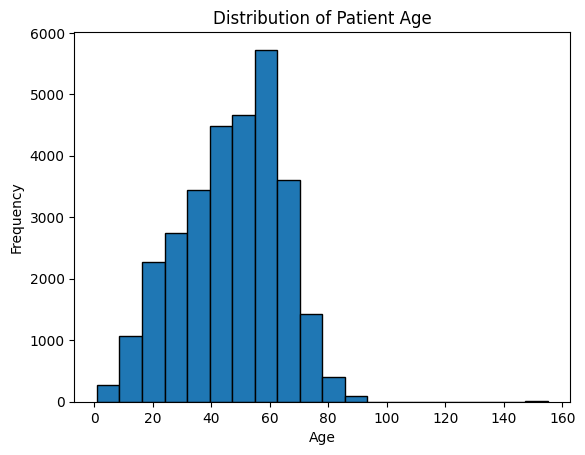

In [23]:
train_data['PatientAge'] = train_data['PatientAge'].astype(float)
plt.hist(train_data['PatientAge'], bins=20, edgecolor='black')
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


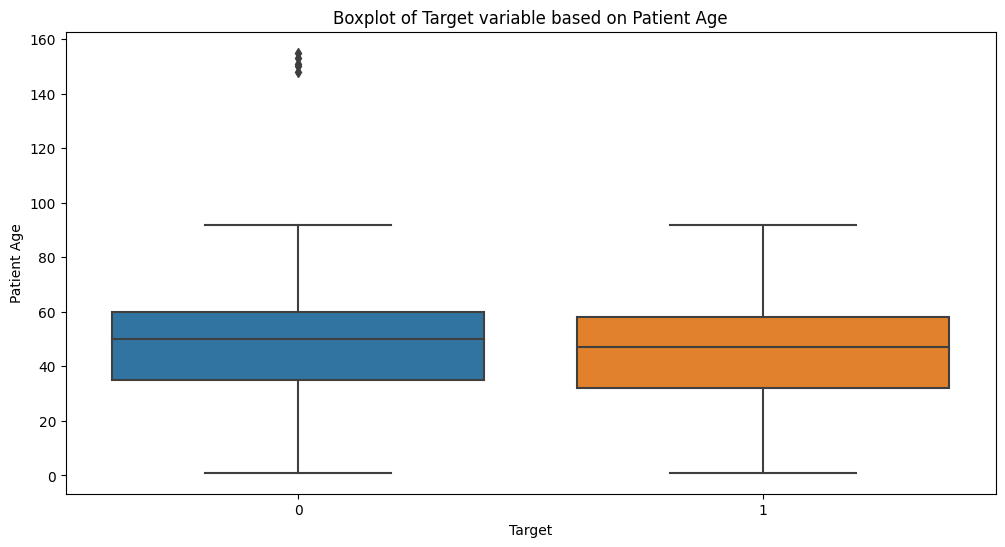

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Target', y='PatientAge', data=train_data)
plt.title('Boxplot of Target variable based on Patient Age')
plt.xlabel('Target')
plt.ylabel('Patient Age')
plt.show()

In [25]:
# Identify rows with 'PatientAge' greater than 110
rows_to_drop = train_data[train_data['PatientAge'] > 110]

# Print the rows to examine
print("Rows with 'PatientAge' greater than 110:")
print(rows_to_drop)

# Drop the identified rows
train_data = train_data.drop(rows_to_drop.index)

# Verify that the rows are dropped
print("DataFrame after dropping rows with 'PatientAge' greater than 110:")
print(train_data)

Rows with 'PatientAge' greater than 110:
                                  patientId   x   y  width  height  Target  \
3921   3b8b8777-a1f6-4384-872a-28b95f59bf0d NaN NaN    NaN     NaN       0   
11032  73aeea88-fc48-4030-8564-0a9d7fdecac4 NaN NaN    NaN     NaN       0   
17213  a4e8e96d-93a6-4251-b617-91382e610fab NaN NaN    NaN     NaN       0   
26488  ec3697bd-184e-44ba-9688-ff8d5fbf9bbc NaN NaN    NaN     NaN       0   
27746  f632328d-5819-4b29-b54f-adf4934bbee6 NaN NaN    NaN     NaN       0   

                              class Modality  PatientAge PatientSex  \
3921                         Normal       CR       148.0          M   
11032  No Lung Opacity / Not Normal       CR       151.0          F   
17213  No Lung Opacity / Not Normal       CR       153.0          M   
26488                        Normal       CR       150.0          M   
27746                        Normal       CR       155.0          F   

      ViewPosition ConversionType  Rows Columns PixelSpacing  


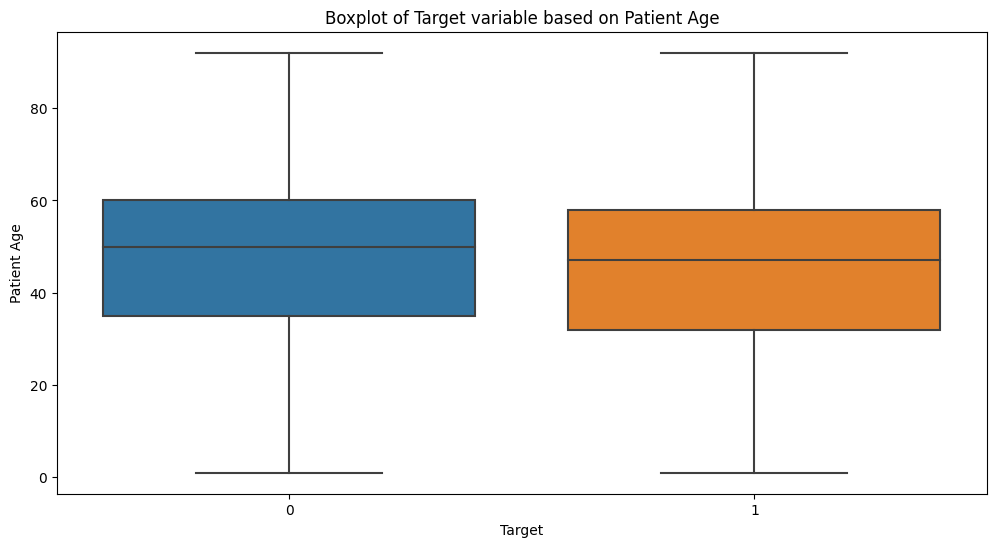

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Target', y='PatientAge', data=train_data)
plt.title('Boxplot of Target variable based on Patient Age')
plt.xlabel('Target')
plt.ylabel('Patient Age')
plt.show()


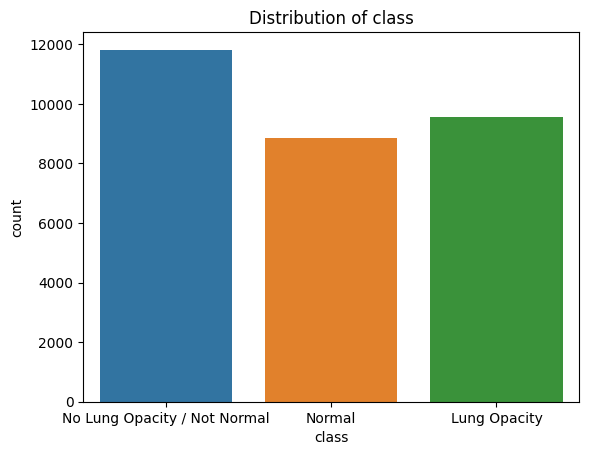

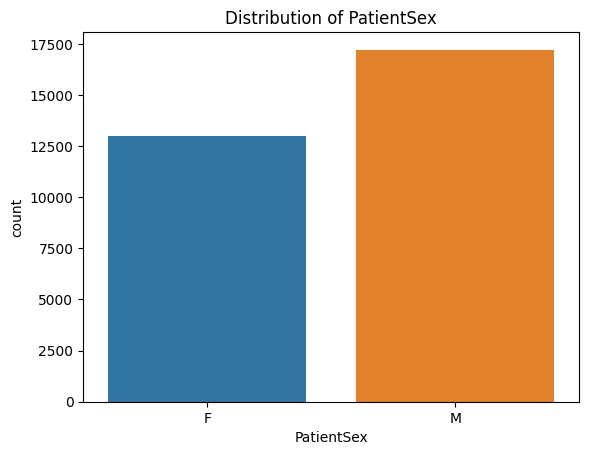

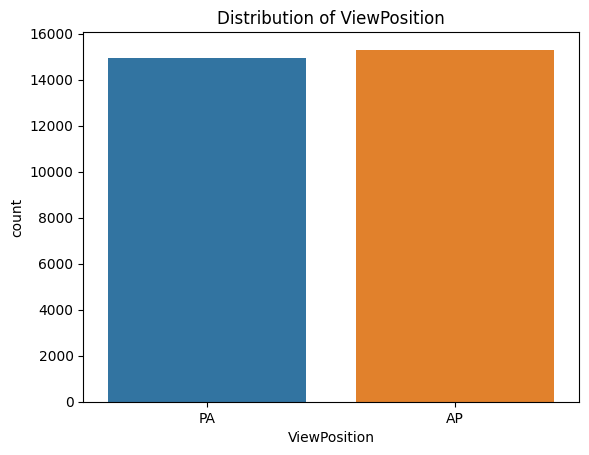

In [39]:
categorical_columns = ['class', 'PatientSex', 'ViewPosition']
for column in categorical_columns:
    sns.countplot(x=column, data=train_data)
    plt.title(f'Distribution of {column}')
    plt.show()


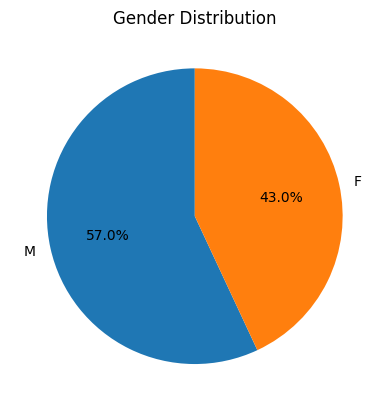

In [40]:
gender_distribution = train_data['PatientSex'].value_counts()
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()

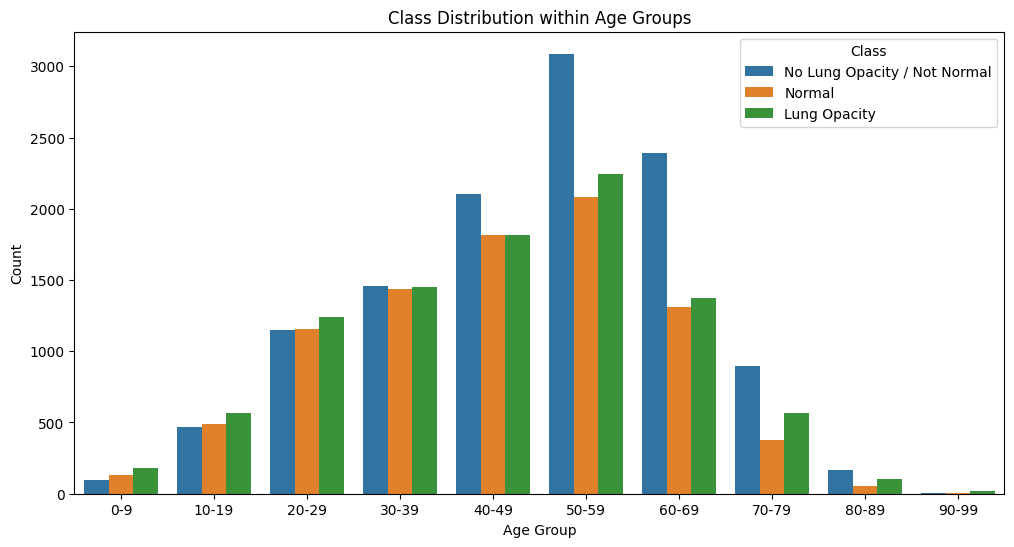

In [41]:
df = train_data
# Convert 'PatientAge' to numeric and create age groups
df['PatientAge'] = pd.to_numeric(df['PatientAge'], errors='coerce')
df['AgeGroup'] = pd.cut(df['PatientAge'], bins=range(0, 110, 10), right=False, labels=[f'{i}-{i+9}' for i in range(0, 100, 10)])

# Count plot for class distribution within age groups
plt.figure(figsize=(12, 6))
sns.countplot(x='AgeGroup', hue='class', data=df)
plt.title('Class Distribution within Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Class')
plt.show()


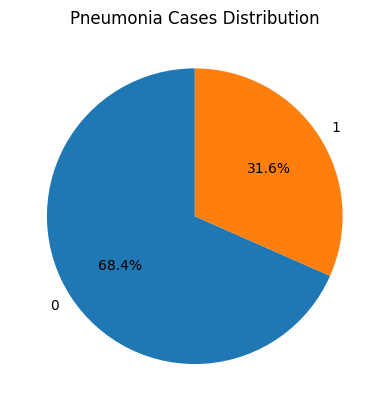

In [42]:
Pneumonia_Cases_distribution = train_data['Target'].value_counts()
plt.pie(Pneumonia_Cases_distribution, labels=Pneumonia_Cases_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Pneumonia Cases Distribution')
plt.show()

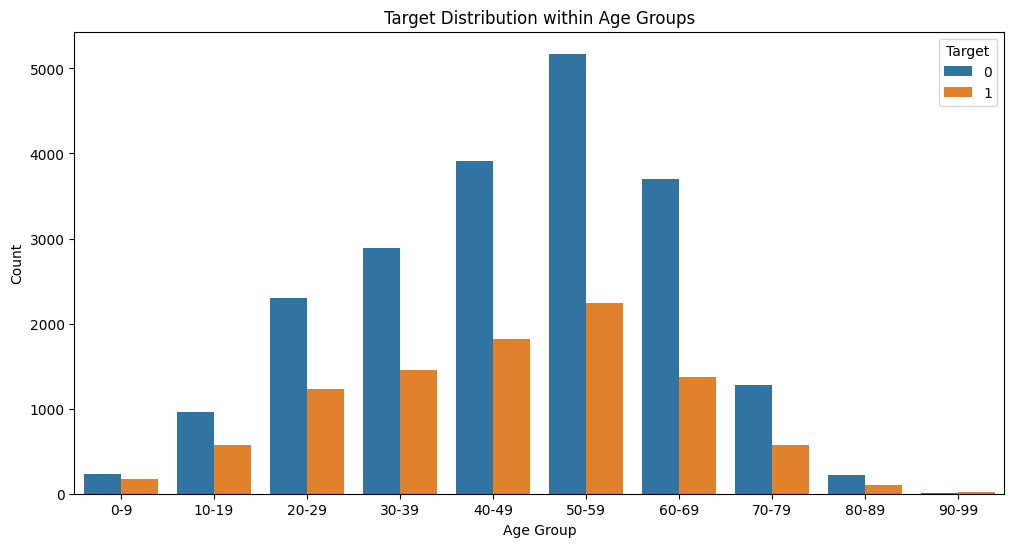

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(x='AgeGroup', hue='Target', data=df)
plt.title('Target Distribution within Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()


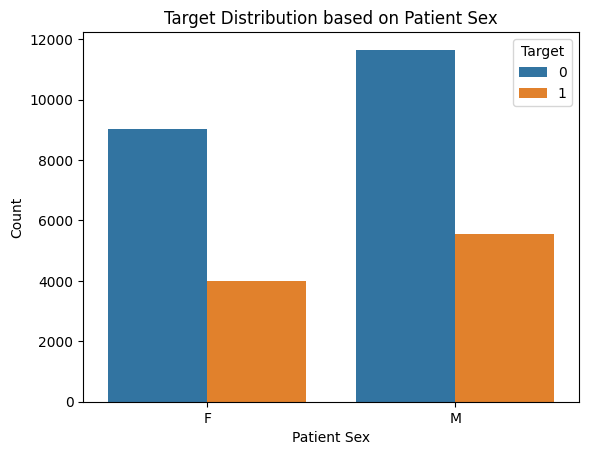

In [44]:
sns.countplot(x='PatientSex', hue='Target', data=df)
plt.title('Target Distribution based on Patient Sex')
plt.xlabel('Patient Sex')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()


**Display images with bounding box**

In [45]:
image_df = train_data[train_data['Target'] == 1]

print(image_df)

                                  patientId      x      y  width  height  \
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
5      00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0   
8      00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0   
9      00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0   
14     00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0   
...                                     ...    ...    ...    ...     ...   
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  316.0  504.0  179.0   273.0   
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  609.0  464.0  240.0   284.0   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target         class Modality  PatientAge PatientSex ViewPosition  \
4          

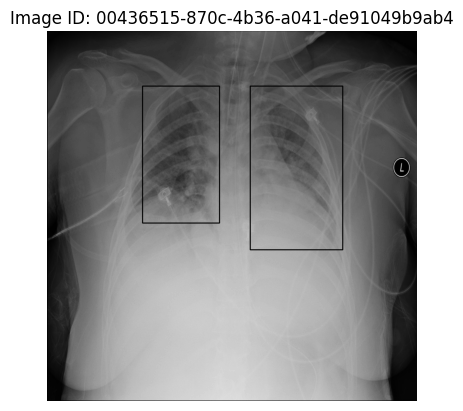

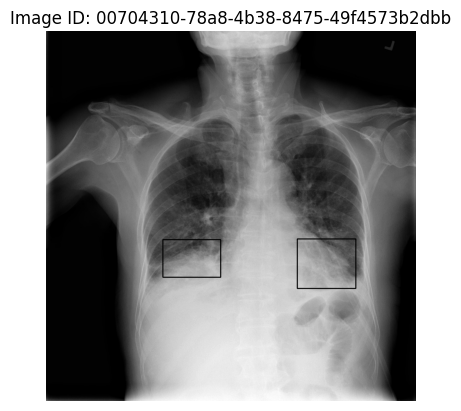

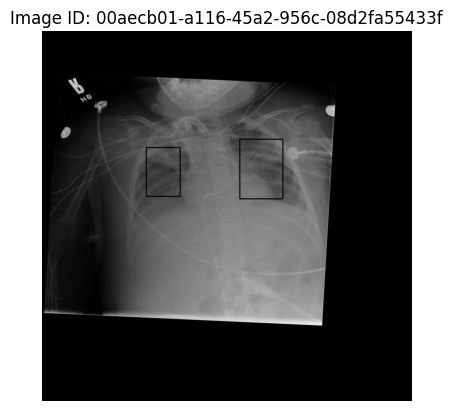

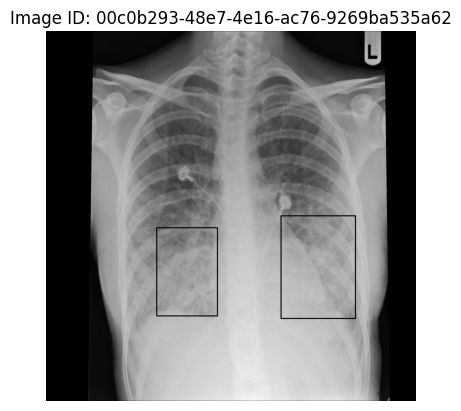

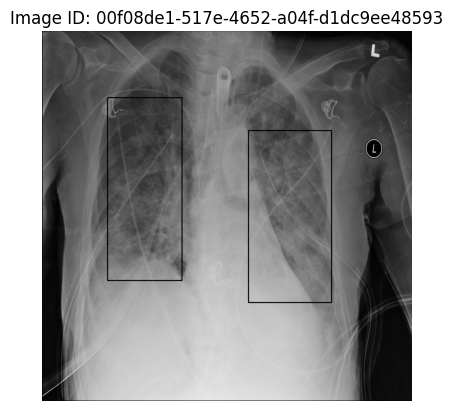

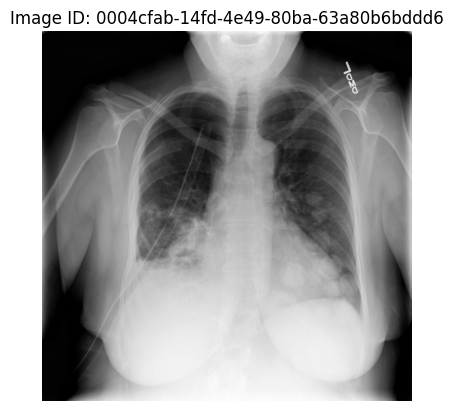

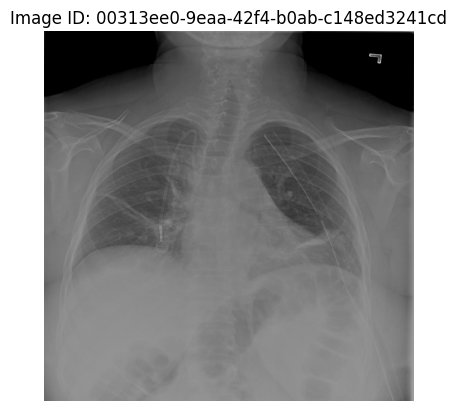

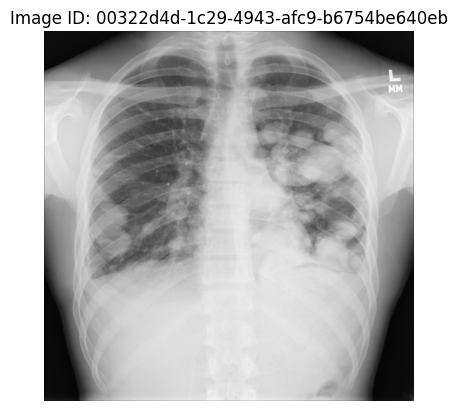

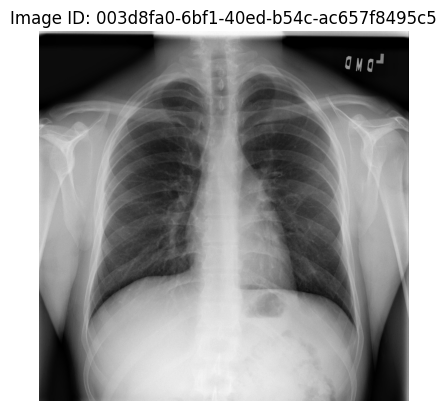

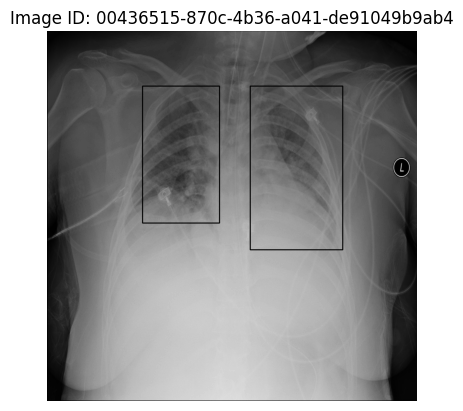

In [46]:
import pydicom

# Step 5: Display images with bounding box
def display_images_with_boxes(image_ids, class_mapping, image_dir):

    for i, image_id in enumerate(image_ids):

        img_path = os.path.join(image_dir, f'{image_id}.dcm')
        img_data = pydicom.dcmread(img_path).pixel_array

        # Get bounding box coordinates for the image
        boxes = class_mapping[class_mapping['patientId'] == image_id][['x', 'y', 'width', 'height']].values
        if not np.isnan(boxes).any():
          for box in boxes:
              cv2.rectangle(img_data, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), color=(0, 255, 0), thickness=2)

        plt.imshow(img_data, cmap='gray')
        plt.title(f'Image ID: {image_id}')
        plt.axis('off')
        plt.show()


# Display images with bounding boxes for the first 5 images
example_image_ids = image_df['patientId'].unique()[:5]
image_dir = 'stage_2_train_images'
display_images_with_boxes(example_image_ids, image_df, image_dir)


train_data_image = train_data['patientId'].unique()[:5]
image_dir = 'stage_2_train_images'
display_images_with_boxes(train_data_image, train_data, image_dir)


**Design, train and test basic CNN models for classification**

In [47]:
import pydicom

# Load and preprocess the images
def load_and_preprocess_images(data, image_dir):
    images = []
    labels = []

    for index, row in data.iterrows():
        image_id = row['patientId']
        label = row['Target']
        img_path = os.path.join(image_dir, f'{image_id}.dcm')

        try:
            img_data = pydicom.dcmread(img_path).pixel_array
            img_data = cv2.resize(img_data, (128, 128))
            images.append(img_data)
            labels.append(label)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")

    images = np.array(images) / 255.0  # Normalize pixel values to be between 0 and 1
    labels = np.array(labels)

    return images, labels

In [48]:
# Load and preprocess images
image_dir = 'stage_2_train_images'
images, labels = load_and_preprocess_images(train_data, image_dir)

In [49]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)

In [50]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

with tf.device('/device:GPU:0'):
# Build the CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # Assuming 2 classes (0 and 1)


In [52]:
# Compile the model
with tf.device('/device:GPU:0'):
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
# Train the model
with tf.device('/device:GPU:0'):
  model.fit(X_train.reshape(-1, 128, 128, 1), y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
605/605 [==============================] - 16s 18ms/step - loss: 0.5198 - accuracy: 0.7475 - val_loss: 0.4676 - val_accuracy: 0.7750
Epoch 2/20
605/605 [==============================] - 9s 16ms/step - loss: 0.4833 - accuracy: 0.7695 - val_loss: 0.4620 - val_accuracy: 0.7825
Epoch 3/20
605/605 [==============================] - 9s 15ms/step - loss: 0.4627 - accuracy: 0.7853 - val_loss: 0.4465 - val_accuracy: 0.7930
Epoch 4/20
605/605 [==============================] - 9s 15ms/step - loss: 0.4380 - accuracy: 0.7967 - val_loss: 0.4552 - val_accuracy: 0.7866
Epoch 5/20
605/605 [==============================] - 9s 15ms/step - loss: 0.4042 - accuracy: 0.8176 - val_loss: 0.4473 - val_accuracy: 0.7980
Epoch 6/20
605/605 [==============================] - 9s 15ms/step - loss: 0.3632 - accuracy: 0.8398 - val_loss: 0.4603 - val_accuracy: 0.8005
Epoch 7/20
605/605 [==============================] - 9s 15ms/step - loss: 0.3213 - accuracy: 0.8595 - val_loss: 0.4736 - val_accuracy: 0.807

In [54]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test.reshape(-1, 128, 128, 1), y_test)
print(f'Test accuracy: {test_acc}')

189/189 [==============================] - 1s 6ms/step - loss: 1.3702 - accuracy: 0.8084
Test accuracy: 0.8084367513656616


In [55]:
# Train the model
with tf.device('/device:GPU:0'):
  model.fit(X_train.reshape(-1, 128, 128, 1), y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
303/303 [==============================] - 9s 28ms/step - loss: 0.0438 - accuracy: 0.9847 - val_loss: 1.2076 - val_accuracy: 0.8191
Epoch 2/20
303/303 [==============================] - 7s 24ms/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 1.3429 - val_accuracy: 0.8249
Epoch 3/20
303/303 [==============================] - 7s 25ms/step - loss: 0.0341 - accuracy: 0.9884 - val_loss: 1.1725 - val_accuracy: 0.8203
Epoch 4/20
303/303 [==============================] - 8s 25ms/step - loss: 0.0291 - accuracy: 0.9897 - val_loss: 1.2875 - val_accuracy: 0.8162
Epoch 5/20
303/303 [==============================] - 7s 24ms/step - loss: 0.0292 - accuracy: 0.9900 - val_loss: 1.3263 - val_accuracy: 0.8205
Epoch 6/20
303/303 [==============================] - 7s 24ms/step - loss: 0.0284 - accuracy: 0.9895 - val_loss: 1.2849 - val_accuracy: 0.8236
Epoch 7/20
303/303 [==============================] - 7s 24ms/step - loss: 0.0287 - accuracy: 0.9908 - val_loss: 1.4247 - val_accuracy: 0.8211

In [56]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test.reshape(-1, 128, 128, 1), y_test)
print(f'Test accuracy: {test_acc}')

189/189 [==============================] - 1s 5ms/step - loss: 1.8724 - accuracy: 0.8303
Test accuracy: 0.8302729725837708


##**Milestone 2**

**Process:**
1. Fine tune the trained basic CNN models for classification.
2. Apply Transfer Learning model for classification
3. Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest.
4. Pickle the model for future prediction
5. Final Report

In [28]:
import pydicom
# Load and preprocess the images (modified for grayscale images)
def load_and_preprocess_images_RGB(data, image_dir):
    images = []
    targets = []
    classLabels = []

    for index, row in data.iterrows():
        image_id = row['patientId']
        target = row['Target']
        classlabel = row["class"]
        img_path = os.path.join(image_dir, f'{image_id}.dcm')

        try:
            img_data = pydicom.dcmread(img_path).pixel_array
                    ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
            if len(img_data.shape) != 3 or img_data.shape[2] != 3:
              img_data = np.stack((img_data,) * 3, -1)

            img = np.array(img_data).astype(np.uint8)
            ## Resize the image
            res = cv2.resize(img,(128,128), interpolation = cv2.INTER_LINEAR)
            images.append(res)
            targets.append(target)
            classLabels.append(classlabel)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")

    images = np.array(images) / 255.0  # Normalize pixel values to be between 0 and 1
    targets = np.array(targets)
    classLabels = np.array(classLabels)

    return images, targets, classLabels


In [29]:
# Load and preprocess images
image_dir = 'stage_2_train_images'
images_rgb, target_rgb, labels_rgb = load_and_preprocess_images_RGB(train_data, image_dir)

In [30]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
y2 = enc.fit_transform(labels_rgb)


In [31]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_rgb, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [32]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [33]:
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [63]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def cnn_model(height, width, num_channels, num_classes, loss, metrics):
    model = Sequential()

    # Add convolutional layers, pooling layers, and dense layers as needed
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, num_channels)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = 'adam'  # You can change this if needed
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

    return model


In [64]:
# Model Summary
cnn_model = cnn_model(128, 128, 3, 3, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [65]:
## Training for 20 epocs with batch size of 30
history = cnn_model.fit(X_train, y_train, epochs = 20, validation_data = (X_val,y_val), batch_size = 64)

Epoch 1/20
331/331 [==============================] - 15s 38ms/step - loss: 0.9529 - accuracy: 0.5403 - val_loss: 0.8645 - val_accuracy: 0.5785
Epoch 2/20
331/331 [==============================] - 9s 27ms/step - loss: 0.8331 - accuracy: 0.6076 - val_loss: 0.8409 - val_accuracy: 0.6023
Epoch 3/20
331/331 [==============================] - 9s 27ms/step - loss: 0.7932 - accuracy: 0.6270 - val_loss: 0.8363 - val_accuracy: 0.5990
Epoch 4/20
331/331 [==============================] - 9s 27ms/step - loss: 0.7484 - accuracy: 0.6543 - val_loss: 0.8436 - val_accuracy: 0.5902
Epoch 5/20
331/331 [==============================] - 9s 27ms/step - loss: 0.6816 - accuracy: 0.6936 - val_loss: 0.8230 - val_accuracy: 0.6204
Epoch 6/20
331/331 [==============================] - 9s 27ms/step - loss: 0.5958 - accuracy: 0.7401 - val_loss: 0.8766 - val_accuracy: 0.6105
Epoch 7/20
331/331 [==============================] - 9s 27ms/step - loss: 0.5101 - accuracy: 0.7824 - val_loss: 0.9249 - val_accuracy: 0.620

In [66]:
## evakualting the acuracy , we have only got accuracy of 43-46% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

142/142 [==============================] - 1s 8ms/step - loss: 2.7972 - accuracy: 0.6345
Test loss: 2.7972404956817627
Test accuracy: 0.6344584226608276


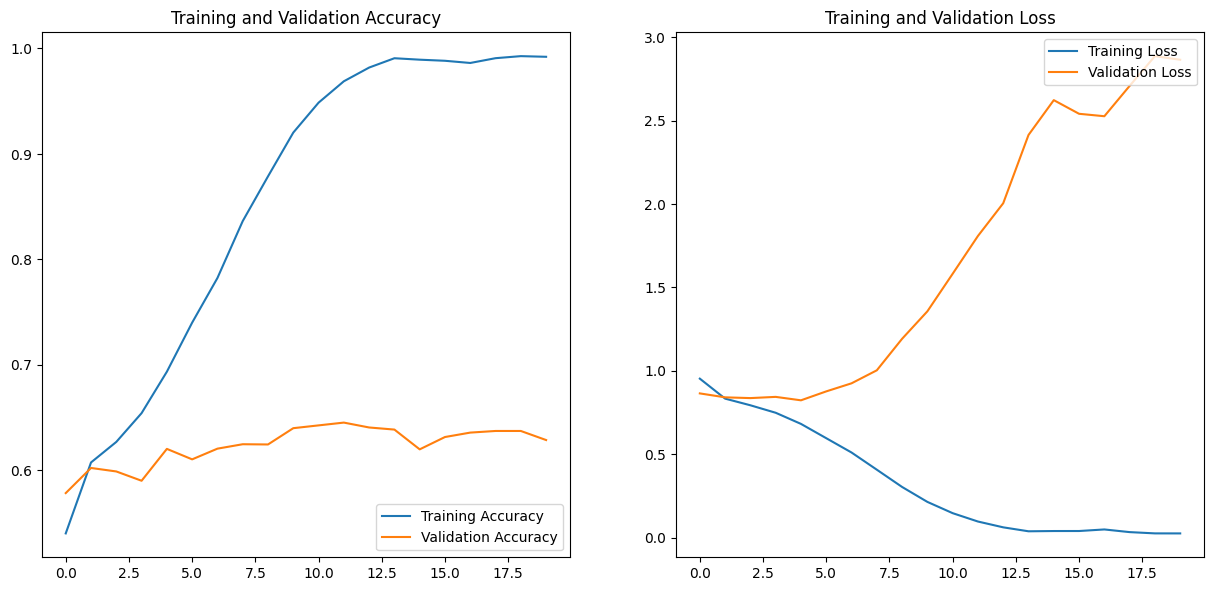

In [67]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models


##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train)
train_val_df = preprocess_input(X_val)


## Adding two hidden later and one softmax layer as an output layer
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_VGG16_model = models.Sequential([ base_model, flatten_layer,dense_layer_1, dense_layer_2,prediction_layer])


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(optimizer='Adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'],)

## Early stopping whe validation accuracy does not change for 7 iteration
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=7,  restore_best_weights=True)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=20, validation_data=(train_val_df,y_val) ,callbacks=es)

Epoch 1/20
662/662 [==============================] - 46s 59ms/step - loss: 0.6346 - accuracy: 0.3863 - val_loss: 0.6229 - val_accuracy: 0.3955
Epoch 2/20
662/662 [==============================] - 33s 50ms/step - loss: 0.6223 - accuracy: 0.4007 - val_loss: 0.6139 - val_accuracy: 0.4129
Epoch 3/20
662/662 [==============================] - 34s 52ms/step - loss: 0.6144 - accuracy: 0.4234 - val_loss: 0.6068 - val_accuracy: 0.4360
Epoch 4/20
662/662 [==============================] - 34s 51ms/step - loss: 0.6126 - accuracy: 0.4279 - val_loss: 0.6211 - val_accuracy: 0.4109
Epoch 5/20
662/662 [==============================] - 34s 51ms/step - loss: 0.6105 - accuracy: 0.4284 - val_loss: 0.6211 - val_accuracy: 0.4127
Epoch 6/20
662/662 [==============================] - 34s 51ms/step - loss: 0.6044 - accuracy: 0.4391 - val_loss: 0.6019 - val_accuracy: 0.4387
Epoch 7/20
662/662 [==============================] - 34s 51ms/step - loss: 0.5996 - accuracy: 0.4494 - val_loss: 0.6305 - val_accuracy:

In [36]:
test_ds = preprocess_input(X_test)
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


142/142 [==============================] - 8s 57ms/step - loss: 0.5739 - accuracy: 0.4983
Test loss: 0.5739491581916809
Test accuracy: 0.4983454644680023


In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)

train_ds = preprocess_input(X_train)
train_val_df = preprocess_input(X_val)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

94765736/94765736 [==============================] - 1s 0us/step


In [39]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history =cnn_resnet_model.fit(train_ds, y_train, epochs=20, validation_data=(train_val_df,y_val))


Epoch 1/20
662/662 [==============================] - 125s 137ms/step - loss: 0.5619 - accuracy: 0.5291 - val_loss: 0.6681 - val_accuracy: 0.3957
Epoch 2/20
662/662 [==============================] - 85s 128ms/step - loss: 0.5022 - accuracy: 0.6088 - val_loss: 0.6576 - val_accuracy: 0.3957
Epoch 3/20
662/662 [==============================] - 85s 128ms/step - loss: 0.4867 - accuracy: 0.6252 - val_loss: 0.9064 - val_accuracy: 0.3494
Epoch 4/20
662/662 [==============================] - 85s 128ms/step - loss: 0.4671 - accuracy: 0.6477 - val_loss: 0.7432 - val_accuracy: 0.3957
Epoch 5/20
662/662 [==============================] - 85s 128ms/step - loss: 0.4553 - accuracy: 0.6533 - val_loss: 1.9827 - val_accuracy: 0.3046
Epoch 6/20
662/662 [==============================] - 85s 128ms/step - loss: 0.4465 - accuracy: 0.6699 - val_loss: 0.9193 - val_accuracy: 0.2997
Epoch 7/20
662/662 [==============================] - 84s 128ms/step - loss: 0.4384 - accuracy: 0.6781 - val_loss: 0.9505 - val_a

In [40]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


142/142 [==============================] - 6s 41ms/step - loss: 9.9869 - accuracy: 0.2936
Test loss: 9.986903190612793
Test accuracy: 0.29362452030181885
